# Resnet

## Please watch Ng C4W2L01-C4W2L04, the first of which is found [here](https://www.youtube.com/watch?v=-bvTzZCEOdM&list=PLkDaE6sCZn6Gl29AoE31iwdVwSG-KnDzF&index=12).

The convolutional neural network that we developed and ran was adequate for use on a small problem with a few classes, but it lacks the explanatory power to produce highly accurate results for more difficult datasets.  Instead, more interesting neural networks have been developed which have greater explanatory power.  One of the most powerful architectures today is called ResNet, which is short for residual network.  

In principle, you could take the network that you've been working on and make it more flexible by adding more convolutional layers, which is to say that we could add more sequences of feature map generation.  This is what is meant when people use the term "deep" learning.  However, if you did this, you would quickly run into the problem that your network would struggle to learn weights in the lower (closer to the inputs) layers of the network.  This is a result of the way that neural networks are trained.  In particular they rely on the ability to take the derivative of a misfit function (e.g. least squares) with respect to a parameter, and to adjust the weight based on that derivative.  However in (naive) deep networks, this gradient has the tendency to become negligibly small as the impact of that weight gets lost in the myriad layers of convolutions and activations closer to the output.  

ResNet solves this problem by ensuring that the information in each weight gets propagated to the output.  It does this by simply adding the layer's input to each layer's output, so instead of 
$$
\mathbf{x}_{l+1} = \mathcal{F}_{l}(\mathbf{x}_l),
$$
at each layer, the neural network performs the operation
$$
\mathbf{x}_{l+1} = \mathcal{F}_{l}(\mathbf{x}_l) + \mathbf{x}_l.
$$
Rearranging this equation, we can see why this architecture is called a residual network:
$$
\mathbf{x}_{l+1} - \mathbf{x}_l = \mathcal{F}_{l}(\mathbf{x}_l).
$$
Each layer is modeling the residual between consecutive feature maps.  The pedantic amongst us will note that this only works when the output of $\mathcal{F}_{l}(\mathbf{x}_l)$ is the same size as the input.  This is dealt with by performing a suitable linear transformation on $\mathbf{x}_l$, making the equation
$$
\mathbf{x}_{l+1} = \mathcal{F}_{l}(\mathbf{x}_l) + W \mathbf{x}_l,
$$
where $W$ is a matrix that has learnable weights.  The matrix $W$ is most often formulated as a convolution with a 1x1 kernel size.   

The addition of the input is known as a *skip connection* because it looks like this:
<img src=res_net.svg width=600/>
The input is run through a normal conv layer (perhaps several) and then added to the output, where it can then be maxpooled or run through an activation or whatever.  

Keras makes these sorts of networks pretty easy to program.  To start with, let's apply this network to the CIFAR-10 classification problem, but we'll do it for all 10 classes.  All the non-model definition code should look the same as our previous example.   

In [23]:
# Source: https://stackoverflow.com/questions/47286441/only-import-keras-takes-10gb-in-gpu
# This added cell fixes an issue with keras loading onto the gpu's RAM preventing larger batch sizes
# and more complicated models.

import tensorflow as tf
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.2)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
from keras import backend as K
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.2
session = tf.Session(config=config)
K.set_session(session)

# GPU confirmation
from tensorflow.python.client import device_lib
print(str(device_lib.list_local_devices()))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15032564760159276259
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1288490188
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1871509369643646625
physical_device_desc: "device: 0, name: GeForce GTX 980 Ti, pci bus id: 0000:01:00.0, compute capability: 5.2"
]


In [3]:
import keras
import keras.datasets as kd

(x_train, y_train), (x_test, y_test) = kd.cifar10.load_data()
labels = ['airplane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

x_train = x_train/255.
x_test = x_test/255.

# Convert class vectors to binary class matrices.
N = len(labels)

y_train = keras.utils.to_categorical(y_train, N)
y_test = keras.utils.to_categorical(y_test, N)

Now things get more interesting.  Obviously, ResNet as described above is more of a concept than a specific architecture: we'll need to make some more specific design choices.  One good way of doing this is to look at the literature and copy what others have done.  In particular, the [original ResNet Paper](https://arxiv.org/abs/1512.03385) provides an example of ResNet being applied to CIFAR-10 that yielded excellent accuracy (state of the art c. 2015).  Here, we'll emulate their network architecture, which looks like this:
<img src=cifar_10_res_net.svg width=900/>
More concretely, the layers of this network up to (and including) the location of the star in the figure above, look like this.

In [24]:
import keras.layers as kl
import keras.regularizers as kr

# Note the alternative method for model specification: no model.add(.), instead we 
# perform sequential operations on layers, then we will make the resulting model later.

# Specify the shape of the input image
input_shape = x_train.shape[1:]
inputs = kl.Input(shape=input_shape)

# First convolution + BN + act
conv = kl.Conv2D(16,(3,3),padding='same',kernel_regularizer=kr.l2(1e-4))(inputs)
bn = kl.BatchNormalization()(conv)
act1 = kl.Activation('relu')(bn)

# Perform 3 convolution blocks
for i in range(3):
    conv = kl.Conv2D(16,(3,3),padding='same',kernel_regularizer=kr.l2(1e-4))(act1)
    bn = kl.BatchNormalization()(conv)
    act = kl.Activation('relu')(bn)
    
    conv = kl.Conv2D(16,(3,3),padding='same',kernel_regularizer=kr.l2(1e-4))(act)
    bn = kl.BatchNormalization()(conv)

    # Skip layer addition
    skip = kl.add([act1,bn])
    act1 = kl.Activation('relu')(skip)  

# Downsampling with strided convolution
conv = kl.Conv2D(32,(3,3),padding='same',strides=2,kernel_regularizer=kr.l2(1e-4))(act1)
bn = kl.BatchNormalization()(conv)
act = kl.Activation('relu')(bn)
conv = kl.Conv2D(32,(3,3),padding='same',kernel_regularizer=kr.l2(1e-4))(act)
bn = kl.BatchNormalization()(conv)

# Downsampling with strided 1x1 convolution
act1_downsampled = kl.Conv2D(32,(1,1),padding='same',strides=2,kernel_regularizer=kr.l2(1e-4))(act1)
# Downsampling skip layer
skip_downsampled = kl.add([act1_downsampled,bn])
act1 = kl.Activation('relu')(skip_downsampled)

# This final layer is denoted by a star in the above figure
for _ in range(2):
    conv = kl.Conv2D(32, (3, 3), padding="same", kernel_regularizer=kr.l2(1e-4))(act1)
    bn = kl.BatchNormalization()(conv)
    act = kl.Activation('relu')(bn)
    
    conv = kl.Conv2D(32, (3,3), padding='same', kernel_regularizer=kr.l2(1e-4))(act)
    bn = kl.BatchNormalization()(conv)
    
    # Skip layer addition
    skip = kl.add([act1,bn])
    act1 = kl.Activation('relu')(skip)
    
# Downsampling with strided convolution
conv = kl.Conv2D(64, (3,3), padding='same', strides=2, kernel_regularizer=kr.l2(1e-4))(act1)
bn = kl.BatchNormalization()(conv)
act = kl.Activation('relu')(bn)
conv = kl.Conv2D(64, (3,3), padding='same', kernel_regularizer=kr.l2(1e-4))(act)
bn = kl.BatchNormalization()(conv)

# Downsampling with strided 1x1 convolution
act1_downsampled = kl.Conv2D(64,(1,1),padding='same',strides=2,kernel_regularizer=kr.l2(1e-4))(act1)
# Downsampling skip layer
skip_downsampled = kl.add([act1_downsampled,bn])
act1 = kl.Activation('relu')(skip_downsampled)

# This final layer is denoted by a star in the above figure
for _ in range(2):
    conv = kl.Conv2D(64, (3, 3), padding="same", kernel_regularizer=kr.l2(1e-4))(act1)
    bn = kl.BatchNormalization()(conv)
    act = kl.Activation('relu')(bn)
    conv = kl.Conv2D(64, (3,3), padding='same', kernel_regularizer=kr.l2(1e-4))(act)
    bn = kl.BatchNormalization()(conv)
    
    # Skip layer addition
    skip = kl.add([act1,bn])
    act1 = kl.Activation('relu')(skip)

Instructions for updating:
Colocations handled automatically by placer.


To ensure that we have the output shape that we expect at this stage, we can look at the shape of act1  

In [25]:
act1

<tf.Tensor 'activation_115/Relu:0' shape=(?, 8, 8, 64) dtype=float32>

Which is an object of size 16x16x32, the correct size based on our chosen architecture (note the first question mark indicates an unknown number of input images: thus if we ran the model on a single photo, this would be a 1, if we ran it on the entire CIFAR training set at once it would be 50000).  As before, we can use this model for classification by doing global average pooling, then the softmax function.

In [26]:
gap = kl.GlobalAveragePooling2D()(act1)
bn = kl.BatchNormalization()(gap)
final_dense = kl.Dense(N)(bn)
softmax = kl.Activation('softmax')(final_dense)

In [27]:
import keras.models as km
model = km.Model(inputs=inputs,outputs=softmax)

# initiate adam optimizer
opt = keras.optimizers.rmsprop(lr=0.001,decay=1e-6)

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=128,
          epochs=100,
          validation_data
          =(x_test, y_test),
          shuffle=True)

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 324s 6ms/step - loss: 1.4761 - acc: 0.4937 - val_loss: 1.7473 - val_acc: 0.4533
Epoch 2/100
50000/50000 [==============================] - 312s 6ms/step - loss: 1.0096 - acc: 0.6703 - val_loss: 1.1662 - val_acc: 0.6215
Epoch 3/100
50000/50000 [==============================] - 320s 6ms/step - loss: 0.8225 - acc: 0.7400 - val_loss: 1.2845 - val_acc: 0.6031
Epoch 4/100
50000/50000 [==============================] - 350s 7ms/step - loss: 0.7081 - acc: 0.7843 - val_loss: 1.2374 - val_acc: 0.6522
Epoch 5/100
50000/50000 [==============================] - 344s 7ms/step - loss: 0.6284 - acc: 0.8128 - val_loss: 1.2262 - val_acc: 0.6416
Epoch 6/100
50000/50000 [==============================] - 337s 7ms/step - loss: 0.5638 - acc: 0.8364 - val_loss: 1.1790 - val_acc: 0.6600
Epoch 7/100
50000/50000 [==============================] - 326s 7ms/step - loss: 0.5125 - acc: 0.8541 - val_loss: 1.

While the code as is works, it is *not* the complete architecture given in the figure above.  **Implement the remainder of the network, and train the model for 100 epochs.** The complete architecture has quite a few parameters, so you'll definitely want to use a GPU, i.e. run it on the cluster (reference the job script included in this repo).

There are also a few extra tidbits to make this work better.  First, we'll want to checkpoint the model, which is to say that we'll want to save the weights anytime the model improves during the training process.  We can do this easily in Keras with a checkpoint function:

In [28]:
import keras.callbacks as kc
filepath = './checkpoints'

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = kc.ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

In [9]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [11]:
from keras.models import model_from_json

# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

Loaded model from disk


Note that these weights can then be loaded into a model on your local machine for more convenient post-processing and visualization of results.  We'll also want to reduce the learning rate as the model reaches an optimal solution.  We can do this with a *learning rate schedule*.


In [29]:
def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 60:
        lr *= 1e-3
    print('Learning rate: ', lr)
    return lr
lr_scheduler = kc.LearningRateScheduler(lr_schedule)

We can include these two functions as *callbacks* to the optimizer:

In [30]:
model.fit(x_train, y_train,
          batch_size=128,
          epochs=100,
          validation_data=(x_test, y_test),
          shuffle=True,
          callbacks=[checkpoint,lr_scheduler])

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
Learning rate:  0.001
50000/50000 [==============================] - 309s 6ms/step - loss: 0.2141 - acc: 0.9821 - val_loss: 1.4598 - val_acc: 0.7731

Epoch 00001: val_acc improved from -inf to 0.77310, saving model to ./checkpoints
Epoch 2/100
Learning rate:  0.001
50000/50000 [==============================] - 308s 6ms/step - loss: 0.2146 - acc: 0.9822 - val_loss: 1.7889 - val_acc: 0.7402

Epoch 00002: val_acc did not improve from 0.77310
Epoch 3/100
Learning rate:  0.001
50000/50000 [==============================] - 308s 6ms/step - loss: 0.2161 - acc: 0.9810 - val_loss: 1.3801 - val_acc: 0.7756

Epoch 00003: val_acc improved from 0.77310 to 0.77560, saving model to ./checkpoints
Epoch 4/100
Learning rate:  0.001
50000/50000 [==============================] - 308s 6ms/step - loss: 0.2148 - acc: 0.9814 - val_loss: 1.4761 - val_acc: 0.7733

Epoch 00004: val_acc did not improve from 0.77560
Epoch 5/100
Learning rate:  0.001
5

50000/50000 [==============================] - 308s 6ms/step - loss: 0.1719 - acc: 0.9938 - val_loss: 1.1007 - val_acc: 0.8212

Epoch 00075: val_acc did not improve from 0.82120
Epoch 76/100
Learning rate:  1e-06
50000/50000 [==============================] - 308s 6ms/step - loss: 0.1719 - acc: 0.9938 - val_loss: 1.0982 - val_acc: 0.8215

Epoch 00076: val_acc improved from 0.82120 to 0.82150, saving model to ./checkpoints
Epoch 77/100
Learning rate:  1e-06
50000/50000 [==============================] - 308s 6ms/step - loss: 0.1701 - acc: 0.9947 - val_loss: 1.0969 - val_acc: 0.8216

Epoch 00077: val_acc improved from 0.82150 to 0.82160, saving model to ./checkpoints
Epoch 78/100
Learning rate:  1e-06
50000/50000 [==============================] - 308s 6ms/step - loss: 0.1695 - acc: 0.9948 - val_loss: 1.0953 - val_acc: 0.8219

Epoch 00078: val_acc improved from 0.82160 to 0.82190, saving model to ./checkpoints
Epoch 79/100
Learning rate:  1e-06
50000/50000 [==============================

In [18]:
def makeCAM(model,imgArray,classIdx):
   
    fig = plt.figure(figsize=(8,8))
    plot_num = 1

    for idx in imgArray:
        last_conv, probs = model.predict(x_train[idx].reshape((1,32,32,3)))
        cam = np.zeros((8,8))
        for i in range(32):
            fm = last_conv[0,:,:,i] # feature map i
            w = final_dense.get_weights()[0][i][classIdx] # weight of feature map i at index 1 (deer)
            cam += fm*w
        cam_upscaled = snd.zoom(cam,4)

        ax = fig.add_subplot(3, 3, plot_num)
        ax.imshow(x_train[idx])
        ax.imshow(cam_upscaled,alpha=0.2,cmap=plt.cm.jet)

        plot_num += 1

Once your model is fitted, **adapt your class activation mapping routine to run on this more advanced architecture, and compute a few examples?  How do these activation maps differ from those computed for the smaller network?**

In [30]:
import keras
import keras.datasets as kd

(x_train, y_train), (x_test, y_test) = kd.cifar10.load_data()
labels = ['airplane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

x_train = x_train/255.
x_test = x_test/255.

# Convert class vectors to binary class matrices.
N = len(labels)

y_train = keras.utils.to_categorical(y_train, N)
y_test = keras.utils.to_categorical(y_test, N)

import keras.layers as kl
import keras.regularizers as kr

# Note the alternative method for model specification: no model.add(.), instead we 
# perform sequential operations on layers, then we will make the resulting model later.

# Specify the shape of the input image
input_shape = x_train.shape[1:]
inputs = kl.Input(shape=input_shape)

# First convolution + BN + act
conv = kl.Conv2D(16,(3,3),padding='same',kernel_regularizer=kr.l2(1e-4))(inputs)
bn = kl.BatchNormalization()(conv)
act1 = kl.Activation('relu')(bn)

# Perform 3 convolution blocks
for i in range(3):
    conv = kl.Conv2D(16,(3,3),padding='same',kernel_regularizer=kr.l2(1e-4))(act1)
    bn = kl.BatchNormalization()(conv)
    act = kl.Activation('relu')(bn)
    
    conv = kl.Conv2D(16,(3,3),padding='same',kernel_regularizer=kr.l2(1e-4))(act)
    bn = kl.BatchNormalization()(conv)

    # Skip layer addition
    skip = kl.add([act1,bn])
    act1 = kl.Activation('relu')(skip)  

# Downsampling with strided convolution
conv = kl.Conv2D(32,(3,3),padding='same',strides=2,kernel_regularizer=kr.l2(1e-4))(act1)
bn = kl.BatchNormalization()(conv)
act = kl.Activation('relu')(bn)
conv = kl.Conv2D(32,(3,3),padding='same',kernel_regularizer=kr.l2(1e-4))(act)
bn = kl.BatchNormalization()(conv)

# Downsampling with strided 1x1 convolution
act1_downsampled = kl.Conv2D(32,(1,1),padding='same',strides=2,kernel_regularizer=kr.l2(1e-4))(act1)
# Downsampling skip layer
skip_downsampled = kl.add([act1_downsampled,bn])
act1 = kl.Activation('relu')(skip_downsampled)

# This final layer is denoted by a star in the above figure
for _ in range(2):
    conv = kl.Conv2D(32, (3, 3), padding="same", kernel_regularizer=kr.l2(1e-4))(act1)
    bn = kl.BatchNormalization()(conv)
    act = kl.Activation('relu')(bn)
    
    conv = kl.Conv2D(32, (3,3), padding='same', kernel_regularizer=kr.l2(1e-4))(act)
    bn = kl.BatchNormalization()(conv)
    
    # Skip layer addition
    skip = kl.add([act1,bn])
    act1 = kl.Activation('relu')(skip)
    
# Downsampling with strided convolution
conv = kl.Conv2D(64, (3,3), padding='same', strides=2, kernel_regularizer=kr.l2(1e-4))(act1)
bn = kl.BatchNormalization()(conv)
act = kl.Activation('relu')(bn)
conv = kl.Conv2D(64, (3,3), padding='same', kernel_regularizer=kr.l2(1e-4))(act)
bn = kl.BatchNormalization()(conv)

# Downsampling with strided 1x1 convolution
act1_downsampled = kl.Conv2D(64,(1,1),padding='same',strides=2,kernel_regularizer=kr.l2(1e-4))(act1)
# Downsampling skip layer
skip_downsampled = kl.add([act1_downsampled,bn])
act1 = kl.Activation('relu')(skip_downsampled)

# This final layer is denoted by a star in the above figure
for _ in range(2):
    conv = kl.Conv2D(64, (3, 3), padding="same", kernel_regularizer=kr.l2(1e-4))(act1)
    bn = kl.BatchNormalization()(conv)
    act = kl.Activation('relu')(bn)
    conv = kl.Conv2D(64, (3,3), padding='same', kernel_regularizer=kr.l2(1e-4))(act)
    bn = kl.BatchNormalization()(conv)
    
    # Skip layer addition
    skip = kl.add([act1,bn])
    act1 = kl.Activation('relu')(skip)
    
gap = kl.GlobalAveragePooling2D()(act1)
bn = kl.BatchNormalization()(gap)
final_dense = kl.Dense(N)(bn)
softmax = kl.Activation('softmax')(final_dense)   
    
    
import keras.models as km
model = km.Model(inputs=inputs,outputs=(bn,softmax))

model.load_weights('./checkpoints')

This thing is a: truck
[[2.5382906e-17 5.4634716e-14 1.1775956e-23 4.0670276e-22 1.5493358e-26
  2.6846262e-22 5.0674815e-24 2.3277106e-18 7.9653869e-19 1.0000000e+00]] ['cat', 'deer', 'ship']


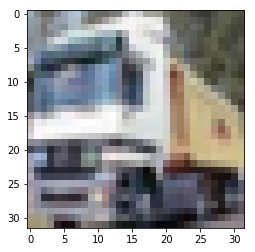

In [32]:
import numpy as np
import matplotlib.pyplot as plt

labels = ['airplane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
test = 1
last_conv, probs = model.predict(x_train[test].reshape((1,32,32,3)))
pred = np.argmax(probs)
print('This thing is a: '+ labels[pred])

plt.imshow(x_train[test])

print(probs, new_labels)

In [33]:
deer_array = [0, 3, 5, 8, 10, 32]

makeCAM(model,deer_array, 4)

IndexError: too many indices for array

<Figure size 576x576 with 0 Axes>